## Курсова робота на тему ""
### Виконав студент гр. ІС-72 Роман Кривохижа

In [3]:
import numpy as np
import pandas as pd
import sys
import scipy.stats as st
from enum import Enum

In [4]:
from IPython.display import display
from IPython.display import clear_output

In [5]:
class Distribution(Enum):
    EXP = 0
    UNIFORM = 1
    NORMAL = 2
    POISSON = 3

In [6]:
class Position:
    def __init__(self, num_of_markers=0, description=None):
        self.num_of_markers = num_of_markers
        self.description = description

    def add_markers(self, num_of_markers):
        self.num_of_markers += num_of_markers

    def remove_markers(self, num_of_markers):
        self.num_of_markers -= num_of_markers

    def __repr__(self):
        return self.description

In [7]:
class Transition:
    def __init__(
        self,
        delay=0,
        delay_distribution=None,
        delay_distribution_params=None,
        priority=1,
        probability=None,
        description=None,
        save_time=False,
        compute_time=False
    ):
        self.delay = delay
        self.delay_distribution = delay_distribution
        self.delay_distribution_params = delay_distribution_params
        self.priority = priority
        self._probability = probability
        self.description = description

        self.in_arcs = []
        self.out_arcs = []

        self.marker_release_timestamps = {}
        
        self.save_time = save_time
        self.compute_time = compute_time

    @property
    def probability(self):
        return self._probability

    def get_random_delay_period(self):
        if self.delay_distribution is Distribution.EXP:
            result = np.random.exponential(**self.delay_distribution_params)
        elif self.delay_distribution is Distribution.UNIFORM:
            result = np.random.uniform(**self.delay_distribution_params)
        elif self.delay_distribution is Distribution.NORMAL:
            result = np.random.normal(**self.delay_distribution_params)
        elif self.delay_distribution is Distribution.POISSON:
            result = np.random.poisson(**self.delay_distribution_params)
        
        global N_ROUND
        return round(result, N_ROUND) #!!!!!

    def check_if_can_perform_transition(self):
        return all(arc.check_start_markers() for arc in self.in_arcs)

    def check_delayed_markers(self, current_time):
        global N_ROUND
        if round(current_time, N_ROUND) in self.marker_release_timestamps.keys():
            del self.marker_release_timestamps[round(current_time, N_ROUND)]
            
            global queue_time, process_time
        
            if self.compute_time:
#                 print('compute:', self)
                process_time.append(current_time - queue_time.pop(0))

            for arc in self.out_arcs:
#                 print('Move to:', arc)
                arc.move_to()

    def perform_transition(self, current_time):
        delay = self.delay if self.delay_distribution is None else self.get_random_delay_period()
        
        global queue_time, process_time
        if self.save_time:
#                 print('save:', self)
            queue_time.append(current_time)
        
        for arc in self.in_arcs:
#             print('Move from:', arc)
            arc.move_from(current_time, delay)

    def __repr__(self):
        return self.description

In [8]:
class Arc:
    def __init__(self, start, end, multiplier=1, informational=False):
        self.start = start
        self.end = end
        self.multiplier = multiplier
        self.informational = informational

        if isinstance(end, Transition):
            end.in_arcs.append(self)  
        elif isinstance(start, Transition):
            start.out_arcs.append(self)

    def check_start_markers(self):
        return self.start.num_of_markers >= self.multiplier

    def move_from(self, current_time, delay):
        if not self.informational:
            self.start.remove_markers(self.multiplier)
        
        global N_ROUND
        release_timestamp = round(current_time + delay, N_ROUND)
        if release_timestamp in self.end.marker_release_timestamps:
            self.end.marker_release_timestamps[release_timestamp] += self.multiplier
        else:
            self.end.marker_release_timestamps[release_timestamp] = self.multiplier
            

    def move_to(self):
        self.end.add_markers(self.multiplier)

    def __repr__(self):
        return f"{self.start} -> {self.end}"


In [9]:
class Model:
    def __init__(self, transitions, positions, arcs, modeling_period, should_print_intermediate_results=False):
        self.transitions = transitions
        self.positions = positions
        self.arcs = arcs
        self.modeling_period = modeling_period
        self.should_print_intermediate_results = should_print_intermediate_results
        
        global N_ROUND
        self.delta_t = round(1/10**N_ROUND, N_ROUND)
        self.time = round(0.000, N_ROUND) if N_ROUND > 1 else 0

        # Stats
        self.position_marker_stats = {position: [] for position in positions}

    def run(self, return_target=False, return_avg_markers=None):
        if self.should_print_intermediate_results:
            self.print_intermediate_results()

        while self.time < self.modeling_period:
            can_perform_transitions = any(
                transition.check_if_can_perform_transition() or len(transition.marker_release_timestamps) > 0
                for transition in self.transitions
            )

            if not can_perform_transitions:
                break

            transitions_without_conflicts = self.get_transitions_with_resolved_conflicts()

            for transition in transitions_without_conflicts:
                if transition.check_if_can_perform_transition():
                    transition.perform_transition(self.time)

            for transition in self.transitions:
                transition.check_delayed_markers(self.time)

            self.calc_stats()

            self.time += self.delta_t

            if self.should_print_intermediate_results:
                self.print_intermediate_results()
        self.result, self.result_target_value = self.print_results(return_target)
        
        if return_avg_markers:
            return self.position_marker_stats[[position for position in self.positions if position.description == return_avg_markers][0]]
        else:
            return self.result_target_value if return_target else self.result

    def get_transitions_with_resolved_conflicts(self):
        resolved_list = []
        conflict_list = []
                
        for position in self.positions:
            output_arcs_for_position = [*filter(lambda arc: arc.start is position, self.arcs)]
            resolved = [*filter(lambda trans: trans.check_if_can_perform_transition(),
                                map(lambda arc: arc.end, output_arcs_for_position))
                       ]
            if len(resolved) > 1:
                conflict_list.append(resolved)

        conf_list_flatten = set(np.array(conflict_list).flatten().tolist())
        for position in self.positions:
            output_arcs_for_position = [*filter(lambda arc: arc.start is position, self.arcs)]
            resolved = [*filter(lambda trans: trans.check_if_can_perform_transition(),
                                map(lambda arc: arc.end, output_arcs_for_position))
                       ]
            
            if not conf_list_flatten.intersection(resolved):
                resolved_list += resolved
        del conf_list_flatten

        # вирішуємо конфлікти
        for conflict in conflict_list:
            # конфлікт за ймовірністю
            if conflict[0]._probability is not None:
                p = [c._probability for c in conflict]
                resolved = np.random.choice(conflict, p=p)
            # конфлікт за пріоритетом
            elif len(np.unique([c.priority for c in conflict if c.priority is not None])) > 1:
                priority = [c.priority for c in conflict]
                resolved = conflict[np.argmax(priority)]
            else:
                resolved = np.random.choice(conflict)
            
            resolved_list += [resolved]
            
#         np.random.shuffle(resolved_list)
        return list(set(resolved_list))

    def calc_stats(self):
        for position in self.positions:
            self.position_marker_stats[position].append(position.num_of_markers)

    def get_result_stats(self):
        result_stats = {position: {} for position in self.positions}

        for position, stats in self.position_marker_stats.items():
            result_stats[position]["avg_markers"] = round(sum(stats) / len(stats), 5)
            result_stats[position]["max_markers"] = max(stats)
            result_stats[position]["min_markers"] = min(stats)
            result_stats[position]["result_markers"] = stats[-1]
            
            if position.description == 'Загальний прибуток від передачі':
                result_revenue_value = stats[-1]
            elif position.description == 'Передано резервним каналом':
                result_reserv_sent_msg = stats[-1]
            elif position.description == 'Кількість переривань':
                result_interuption_cnt = stats[-1]
            elif position.description == 'Загальна кількість переданих повідомлень':
                result_msg_cnt = stats[-1]

        return result_stats, {'Загальний прибуток від передачі': result_revenue_value,
                              'Передано резервним каналом': result_reserv_sent_msg,
                              'Частота переривань (N_interupt/Time)': round(result_interuption_cnt / self.time, 5),
                              'Доля перерваних повідомлень': round(result_interuption_cnt / result_msg_cnt, 5)}

    def print_results(self, return_target):
        result_stats, result_target_value = self.get_result_stats()
        formatted_records = []

        for position, stats in result_stats.items():
            record = stats
            record["description"] = position.description

            formatted_records.append(record)
        
        if not return_target:
            print(f"Modeling time spent: {self.time}")
            display(pd.DataFrame(
                formatted_records,
                columns=[
                    "description",
                    "avg_markers",
                    "max_markers",
                    "min_markers",
                    "result_markers"
                ]
            ))

        return result_stats, result_target_value

    def print_intermediate_results(self):
        print(f"Timestamp: {self.time}")
        print("--- Positions ---")
        for position in self.positions:
            print(position, position.num_of_markers)
        print("--- Transitions ---")
        for t in self.transitions:
            print(t, t.marker_release_timestamps)
        print()

### Моделювання задачі

#### Оголошення структури системи

In [10]:
def define_model(modeling_period, should_print_intermediate_results=False, **kwargs):
    k = np.abs(kwargs['T2_basic'] - kwargs['T2'])
    
    generator = Position(num_of_markers=1, description="Надходження")
    queue = Position(num_of_markers=0, description="Накопичувач (черга)")

    basic_channel_is_available = Position(num_of_markers=1, description="Основний канал вільний")
    reserv_channel_is_available = Position(num_of_markers=1, description="Резервний канал вільний")

    buffer = Position(num_of_markers=0, description="Буфер")
    innterupts_cnt = Position(num_of_markers=0, description="Кількість переривань")

    basic_result_revenue = Position(num_of_markers=0, description="Прибуток від передачі основним каналом")
    basic_result = Position(num_of_markers=0, description="Передано основним каналом")

    general_result_revenue = Position(num_of_markers=0, description="Загальний прибуток від передачі")
    general_result = Position(num_of_markers=0, description="Загальна кількість переданих повідомлень")

    reserv_result_revenue = Position(num_of_markers=0, description="Прибуток від передачі резервним каналом")
    reserv_result = Position(num_of_markers=0, description="Передано резервним каналом")

    accessibility_marker = Position(num_of_markers=1, description="Маркер доступу до основного каналу")

    total_failurs = Position(num_of_markers=0, description="Загальна кількість збоїв")

    p2 = Position(num_of_markers=1, description="P2")
    fixed_failure = Position(num_of_markers=0, description="Збій усунено")
    p1 = Position(num_of_markers=1, description="P1")

    was_failure = Position(num_of_markers=0, description="Відбувся збій")
    need_to_run_reserv_channel = Position(num_of_markers=0, description="Потрібно запустити резервний канал")
    reserv_channel_has_been_started = Position(num_of_markers=0, description="Резервний канал запущено")

    # Transitions
    message_arrived_T = Transition(
        delay_distribution=Distribution.UNIFORM,
        delay_distribution_params={"low": kwargs['R'] - kwargs['R_RANGE'], "high": kwargs['R'] + kwargs['R_RANGE']},
        description="Перехід до накопичувача",
        save_time=True
    )

    basic_channel_T = Transition(
        delay_distribution=Distribution.UNIFORM,
        delay_distribution_params={"low": kwargs['T1'] - kwargs['T1_RANGE'], "high": kwargs['T1'] + kwargs['T1_RANGE']},
        description="Основний канал"
    )

    sending_finished_T = Transition(
        delay=0,
        description="Завершення надсилання",
        compute_time=True
    )

    innterupting_T = Transition(
        delay=0,
        priority=2,
        description="Переривання"
    )

    reserv_chanel_T = Transition(
        delay_distribution=Distribution.UNIFORM,
        delay_distribution_params={"low": kwargs['T1'] - kwargs['T1_RANGE'], "high": kwargs['T1'] + kwargs['T1_RANGE']},
        priority=2,
        description="Резервний канал",
        compute_time=True
    )

    recording_failure_T = Transition(
        delay=0,
        description="Запис збою"
    )

    fixing_failure_T = Transition(
        delay_distribution=Distribution.UNIFORM,
        delay_distribution_params={"low": kwargs['T4'] - kwargs['T4_RANGE'], "high": kwargs['T4'] + kwargs['T4_RANGE']},
        description="Усунення збою"
    )

    returning_marker_T = Transition(
        delay=0,
        description="Повернення маркеру"
    )

    failure_generation_T = Transition(
        delay_distribution=Distribution.UNIFORM,
        delay_distribution_params={"low": kwargs['T2'] - kwargs['T2_RANGE'], "high": kwargs['T2'] + kwargs['T2_RANGE']},
        description="Генерація збою"
    )

    starting_reserv_channel_T = Transition(
        delay=T3,
        description="Запуск резервного каналу"
    )


    # Arcs
    a1 = Arc(start=generator, end=message_arrived_T)
    a_1 = Arc(start=message_arrived_T, end=generator)

    a2 = Arc(start=message_arrived_T, end=queue)

    a3 = Arc(start=queue, end=basic_channel_T)
    a4 = Arc(start=innterupting_T, end=queue)
    a5 = Arc(start=queue, end=reserv_chanel_T)

    a6 = Arc(start=accessibility_marker, end=basic_channel_T, informational=True)
    a7 = Arc(start=basic_channel_T, end=buffer)
    a21 = Arc(start=basic_channel_T, end=basic_channel_is_available)
    a22 = Arc(start=basic_channel_is_available, end=basic_channel_T)

    a8 = Arc(start=buffer, end=sending_finished_T)
    a9 = Arc(start=buffer, end=innterupting_T)

    a10 = Arc(start=sending_finished_T, end=basic_result_revenue, multiplier=kwargs['s1']-k*kwargs['s3'])
    a11 = Arc(start=sending_finished_T, end=basic_result)
    a12 = Arc(start=sending_finished_T, end=general_result_revenue, multiplier=kwargs['s1']-k*kwargs['s3'])
    a13 = Arc(start=sending_finished_T, end=general_result)

    a14 = Arc(start=innterupting_T, end=innterupts_cnt)
    a24 = Arc(start=was_failure, end=innterupting_T, informational=True)

    a15 = Arc(start=reserv_chanel_T, end=general_result_revenue, multiplier=kwargs['s2']-k*kwargs['s3'])
    a16 = Arc(start=reserv_chanel_T, end=general_result)
    a17 = Arc(start=reserv_chanel_T, end=reserv_result_revenue, multiplier=kwargs['s2']-k*kwargs['s3'])
    a18 = Arc(start=reserv_chanel_T, end=reserv_result)

    a19 = Arc(start=reserv_chanel_T, end=reserv_channel_is_available)
    a20 = Arc(start=reserv_channel_is_available, end=reserv_chanel_T)

    a23 = Arc(start=reserv_channel_has_been_started, end=reserv_chanel_T, informational=True)
    a24 = Arc(start=reserv_channel_has_been_started, end=returning_marker_T)
    a25 = Arc(start=starting_reserv_channel_T, end=reserv_channel_has_been_started)

    a26 = Arc(start=need_to_run_reserv_channel, end=starting_reserv_channel_T)

    a27 = Arc(start=failure_generation_T, end=need_to_run_reserv_channel)
    a28 = Arc(start=failure_generation_T, end=was_failure)
    a29 = Arc(start=was_failure, end=fixing_failure_T, informational=True)
    a30 = Arc(start=was_failure, end=recording_failure_T, informational=True)
    a33 = Arc(start=was_failure, end=returning_marker_T)

    a31 = Arc(start=p2, end=fixing_failure_T)
    a32 = Arc(start=returning_marker_T, end=p2)

    a34 = Arc(start=fixing_failure_T, end=fixed_failure)
    a35 = Arc(start=fixed_failure, end=returning_marker_T)

    a36 = Arc(start=returning_marker_T, end=accessibility_marker)
    a37 = Arc(start=returning_marker_T, end=p1)

    a38 = Arc(start=p1, end=failure_generation_T)

    a39 = Arc(start=accessibility_marker, end=recording_failure_T)
    a40 = Arc(start=recording_failure_T, end=total_failurs)


    arcs = [a1,a_1,a2,a3,a4,a5,a6,a7,a21,a22,a8,a9,a10,a11,a12,a13,a14,a24,a15,a16,a17,a18,
            a19,a20,a23,a24,a25,a26,a27,a28,a29,a30,a33,a31,a32,a34,a35,a36,a37,a38,a39,a40]

    net = Model(
        positions=[
            generator,
            queue,

            basic_channel_is_available,
            reserv_channel_is_available,

            buffer,
            innterupts_cnt,

            basic_result_revenue,
            basic_result,

            general_result_revenue,
            general_result,

            reserv_result_revenue,
            reserv_result,

            accessibility_marker,

            total_failurs,

            p2,
            fixed_failure,
            p1,

            was_failure,
            need_to_run_reserv_channel,
            reserv_channel_has_been_started
        ],
        transitions=[
            message_arrived_T,
            basic_channel_T,
            sending_finished_T,
            innterupting_T,
            reserv_chanel_T,
            recording_failure_T,
            fixing_failure_T,
            returning_marker_T,
            failure_generation_T,
            starting_reserv_channel_T
        ],
        arcs=arcs,
        modeling_period=modeling_period,
        should_print_intermediate_results=False
    )
    return net

#### Моделювання системи з заданими параметрами

In [11]:
T1 = 20
T1_RANGE = 8

T2_basic = 400
T2 = 400
T2_RANGE = 50

T3 = 5

T4 = 100
T4_RANGE = 25

s1 = 60
s2 = 30
s3 = 0.04

R = 18
R_RANGE = 10

k = np.abs(T2_basic - T2)

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0
queue_time = []
process_time = []

# Positions
net = define_model(modeling_period, should_print_intermediate_results=False,
                   T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                   T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
result = net.run(return_target=False)

Modeling time spent: 10000.0


,description,avg_markers,max_markers,min_markers,result_markers
0,Надходження,0.0534,1.0,0,0.0
1,Накопичувач (черга),34.6305,68.0,0,68.0
2,Основний канал вільний,0.2258,1.0,0,0.0
3,Резервний канал вільний,0.8019,1.0,0,1.0
4,Буфер,0.0387,1.0,0,0.0
5,Кількість переривань,9.3104,19.0,0,19.0
6,Прибуток від передачі основним каналом,11023.2300,22080.0,0,22080.0
7,Передано основним каналом,183.7205,368.0,0,368.0
8,Загальний прибуток від передачі,12493.2630,24990.0,0,24990.0
9,Загальна кількість переданих повідомлень,232.7216,465.0,0,465.0


#### Оцінка адекватності

In [50]:
T1 = 20
T1_RANGE = 8

T2_basic = 400
T2 = 400
T2_RANGE = 50

T3 = 5

T4 = 100
T4_RANGE = 25

s1 = 60
s2 = 30
s3 = 0.04

R = 18
R_RANGE = 10

k = np.abs(T2_basic - T2)

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0

n_exp = 50
y_hat_list = []

for i in tqdm(range(n_exp)):
    net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
    result = net.run(return_target=True)
    y_hat_list.append(result['Загальний прибуток від передачі'])
    
    
net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
result = net.run(return_target=True)
result = result['Загальний прибуток від передачі']

100%|██████████| 50/50 [02:14<00:00,  2.68s/it]


In [51]:
std_hat = np.std(y_hat_list, ddof=1)
mean_hat = np.mean(y_hat_list)

In [52]:
if (mean_hat - std_hat) < result and result < (mean_hat + std_hat):
    print('Проведено метод середніх сум. Визначено, що система поводить себе адекватно.')

In [75]:
# x5 = x4 * 100 / (300 + k)
# x4 = T/18 - x5



# x5 = (T/18 - x5)*100 / (300 + k)



# х5*300 + x5*k = 100T/18 - 100*x5

# (400 + k) * x5 = 100T / 18



# x5 = 100T/(18*(400+k))

# x4 = T/18 - 100T/(18*(400+k))

#### Верифікація

In [53]:
from itertools import product
from tqdm import tqdm

**побудуємо загальну таблицю та спробуємо змінити багато параметрів:**

In [54]:
T1_list = [15, 20, 25]
T1_RANGE_list = [8]

T2_basic = 400
T2_list = [300, 400, 500]
T2_RANGE_list = [50]

T3_list = [3, 5, 8]

T4_list = [75, 100, 125]
T4_RANGE = [25]

s1 = 60
s2 = 30
s3 = 0.04

R_list = [15, 18, 21]
R_RANGE_list = [10]

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0
queue_time = []
process_time = []

df_rows = []
for row in tqdm(product(T1_list, T1_RANGE_list, T2_list, T2_RANGE_list, T3_list, T4_list, T4_RANGE, R_list, R_RANGE_list)):
    T1, T1_RANGE, T2, T2_RANGE, T3, T4, T4_RANGE, R, R_RANGE = row
    k = np.abs(T2_basic - T2)
    
    net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
    result = net.run(return_target=True)
    df_rows.append(dict({'T1': T1, 'T1_RANGE': T1_RANGE, 'T2': T2, 'T2_RANGE': T2_RANGE, 'T3': T3,
                    'T4': T4, 'T4_RANGE': T4_RANGE, 'k': k, 's1': s1-k*s3, 's2': s2-k*s3, 's3': s3,
                    'modeling_time': modeling_period}, **result))
    
df = pd.DataFrame(df_rows)
df.head(10)

243it [10:45,  2.66s/it]


,T1,T1_RANGE,T2,T2_RANGE,T3,T4,T4_RANGE,k,s1,s2,s3,modeling_time,Загальний прибуток від передачі,Передано резервним каналом,Частота переривань (N_interupt/Time),Доля перерваних повідомлень
0,15,8,300,50,3,75,25,100,56.0,26.0,0.04,10000.0,29776.0,120,0.0026,0.04362
1,15,8,300,50,3,75,25,100,56.0,26.0,0.04,10000.0,25666.0,117,0.0022,0.04223
2,15,8,300,50,3,75,25,100,56.0,26.0,0.04,10000.0,22180.0,110,0.0018,0.03956
3,15,8,300,50,3,100,25,100,56.0,26.0,0.04,10000.0,28396.0,166,0.0025,0.04195
4,15,8,300,50,3,100,25,100,56.0,26.0,0.04,10000.0,25396.0,154,0.0023,0.04291
5,15,8,300,50,3,100,25,100,56.0,26.0,0.04,10000.0,21136.0,128,0.0019,0.04260
6,15,8,300,50,3,125,25,100,56.0,26.0,0.04,10000.0,29092.0,182,0.0022,0.03566
7,15,8,300,50,3,125,25,100,56.0,26.0,0.04,10000.0,24024.0,168,0.0017,0.03276
8,15,8,300,50,3,125,25,100,56.0,26.0,0.04,10000.0,21186.0,145,0.0016,0.03509
9,15,8,300,50,5,75,25,100,56.0,26.0,0.04,10000.0,30720.0,124,0.0028,0.04553


In [55]:
df.sort_values('Загальний прибуток від передачі', ascending=False).head(10)

,T1,T1_RANGE,T2,T2_RANGE,T3,T4,T4_RANGE,k,s1,s2,s3,modeling_time,Загальний прибуток від передачі,Передано резервним каналом,Частота переривань (N_interupt/Time),Доля перерваних повідомлень
27,15,8,400,50,3,75,25,0,60.0,30.0,0.04,10000.0,34200.0,104,0.0021,0.03376
45,15,8,400,50,8,75,25,0,60.0,30.0,0.04,10000.0,33870.0,93,0.0020,0.03273
36,15,8,400,50,5,75,25,0,60.0,30.0,0.04,10000.0,33780.0,102,0.0020,0.03257
48,15,8,400,50,8,100,25,0,60.0,30.0,0.04,10000.0,33540.0,124,0.0021,0.03382
30,15,8,400,50,3,100,25,0,60.0,30.0,0.04,10000.0,32730.0,135,0.0019,0.03100
39,15,8,400,50,5,100,25,0,60.0,30.0,0.04,10000.0,32520.0,130,0.0020,0.03295
51,15,8,400,50,8,125,25,0,60.0,30.0,0.04,10000.0,32310.0,147,0.0021,0.03431
42,15,8,400,50,5,125,25,0,60.0,30.0,0.04,10000.0,32190.0,147,0.0018,0.02951
63,15,8,500,50,5,75,25,100,56.0,26.0,0.04,10000.0,32092.0,82,0.0016,0.02593
54,15,8,500,50,3,75,25,100,56.0,26.0,0.04,10000.0,31968.0,88,0.0017,0.02751


In [56]:
df.sort_values('Загальний прибуток від передачі', ascending=False).to_excel('assets/verification_all.xlsx', index=False)

**побудуємо таблицю, де будемо змінювати лише k:**

In [57]:
T1_list = [20]
T1_RANGE_list = [8]

T2_basic = 400
T2_list = list(range(400, 451))
T2_RANGE_list = [50]

T3_list = [5]

T4_list = [100]
T4_RANGE = [25]

s1 = 60
s2 = 30
s3 = 0.04

R_list = [18]
R_RANGE_list = [10]

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0
queue_time = []
process_time = []

df_rows = []
for row in tqdm(product(T1_list, T1_RANGE_list, T2_list, T2_RANGE_list, T3_list, T4_list, T4_RANGE, R_list, R_RANGE_list)):
    T1, T1_RANGE, T2, T2_RANGE, T3, T4, T4_RANGE, R, R_RANGE = row
    k = np.abs(T2_basic - T2)
    
    net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
    result = net.run(return_target=True)
    df_rows.append(dict({'T1': T1, 'T1_RANGE': T1_RANGE, 'T2': T2, 'T2_RANGE': T2_RANGE, 'T3': T3,
                    'T4': T4, 'T4_RANGE': T4_RANGE, 'k': k, 's1': s1-k*s3, 's2': s2-k*s3, 's3': s3,
                    'modeling_time': modeling_period}, **result))
    
df = pd.DataFrame(df_rows)
df.head(10)

51it [02:16,  2.68s/it]


,T1,T1_RANGE,T2,T2_RANGE,T3,T4,T4_RANGE,k,s1,s2,s3,modeling_time,Загальний прибуток від передачі,Передано резервним каналом,Частота переривань (N_interupt/Time),Доля перерваних повідомлень
0,20,8,400,50,5,100,25,0,60.00,30.00,0.04,10000.0,25230.00,105,0.0020,0.04228
1,20,8,401,50,5,100,25,1,59.96,29.96,0.04,10000.0,25181.40,90,0.0020,0.04301
2,20,8,402,50,5,100,25,2,59.92,29.92,0.04,10000.0,24772.96,99,0.0020,0.04320
3,20,8,403,50,5,100,25,3,59.88,29.88,0.04,10000.0,25024.20,94,0.0021,0.04516
4,20,8,404,50,5,100,25,4,59.84,29.84,0.04,10000.0,25034.80,103,0.0020,0.04255
5,20,8,405,50,5,100,25,5,59.80,29.80,0.04,10000.0,25166.40,94,0.0019,0.04060
6,20,8,406,50,5,100,25,6,59.76,29.76,0.04,10000.0,25446.24,96,0.0022,0.04641
7,20,8,407,50,5,100,25,7,59.72,29.72,0.04,10000.0,24590.92,98,0.0019,0.04121
8,20,8,408,50,5,100,25,8,59.68,29.68,0.04,10000.0,24363.44,99,0.0020,0.04367
9,20,8,409,50,5,100,25,9,59.64,29.64,0.04,10000.0,24614.04,96,0.0020,0.04338


In [58]:
df.sort_values('Загальний прибуток від передачі', ascending=False).head(10)

,T1,T1_RANGE,T2,T2_RANGE,T3,T4,T4_RANGE,k,s1,s2,s3,modeling_time,Загальний прибуток від передачі,Передано резервним каналом,Частота переривань (N_interupt/Time),Доля перерваних повідомлень
6,20,8,406,50,5,100,25,6,59.76,29.76,0.04,10000.0,25446.24,96,0.0022,0.04641
32,20,8,432,50,5,100,25,32,58.72,28.72,0.04,10000.0,25425.60,92,0.0019,0.03958
15,20,8,415,50,5,100,25,15,59.40,29.40,0.04,10000.0,25335.00,96,0.0019,0.04000
34,20,8,434,50,5,100,25,34,58.64,28.64,0.04,10000.0,25301.28,89,0.0019,0.03983
12,20,8,412,50,5,100,25,12,59.52,29.52,0.04,10000.0,25243.92,93,0.0019,0.04034
11,20,8,411,50,5,100,25,11,59.56,29.56,0.04,10000.0,25233.64,90,0.0019,0.04051
0,20,8,400,50,5,100,25,0,60.00,30.00,0.04,10000.0,25230.00,105,0.0020,0.04228
1,20,8,401,50,5,100,25,1,59.96,29.96,0.04,10000.0,25181.40,90,0.0020,0.04301
22,20,8,422,50,5,100,25,22,59.12,29.12,0.04,10000.0,25172.00,97,0.0019,0.04000
5,20,8,405,50,5,100,25,5,59.80,29.80,0.04,10000.0,25166.40,94,0.0019,0.04060


In [59]:
temp_xy = df.sort_values('k', ascending=True)[['k', 'Загальний прибуток від передачі']].values

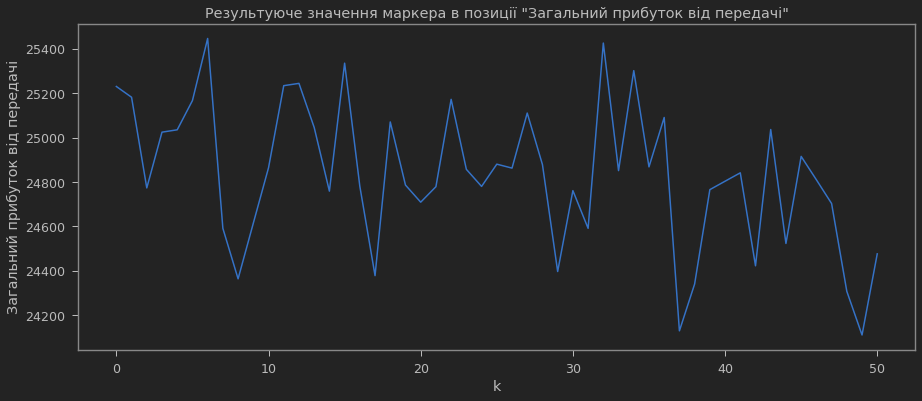

In [60]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.plot(temp_xy[:, 0], temp_xy[:, 1])

ax.set_xlabel(u'k')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Загальний прибуток від передачі')
ax.set_title(u'Результуюче значення маркера в позиції "Загальний прибуток від передачі"');

In [61]:
del temp_xy

In [62]:
df.sort_values('Загальний прибуток від передачі', ascending=False).to_excel('assets/verification_T2.xlsx', index=False)

**зафіксуємо час моделювання для кожного переходу та будемо змінювати лише k:**

In [63]:
T1_list = [20]
T1_RANGE_list = [0]

T2_basic = 400
T2_list = list(range(400, 451))
T2_RANGE_list = [0]

T3_list = [5]

T4_list = [100]
T4_RANGE = [0]

s1 = 60
s2 = 30
s3 = 0.04

R_list = [18]
R_RANGE_list = [0]

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0
queue_time = []
process_time = []

df_rows = []
for row in tqdm(product(T1_list, T1_RANGE_list, T2_list, T2_RANGE_list, T3_list, T4_list, T4_RANGE, R_list, R_RANGE_list)):
    T1, T1_RANGE, T2, T2_RANGE, T3, T4, T4_RANGE, R, R_RANGE = row
    k = np.abs(T2_basic - T2)
    
    net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
    result = net.run(return_target=True)
    df_rows.append(dict({'T1': T1, 'T1_RANGE': T1_RANGE, 'T2': T2, 'T2_RANGE': T2_RANGE, 'T3': T3,
                    'T4': T4, 'T4_RANGE': T4_RANGE, 'k': k, 's1': s1-k*s3, 's2': s2-k*s3, 's3': s3,
                    'modeling_time': modeling_period}, **result))
    
df = pd.DataFrame(df_rows)
df.head(10)

51it [02:16,  2.68s/it]


,T1,T1_RANGE,T2,T2_RANGE,T3,T4,T4_RANGE,k,s1,s2,s3,modeling_time,Загальний прибуток від передачі,Передано резервним каналом,Частота переривань (N_interupt/Time),Доля перерваних повідомлень
0,20,0,400,0,5,100,0,0,60.00,30.00,0.04,10000.0,25620.00,96,0.0020,0.04211
1,20,0,401,0,5,100,0,1,59.96,29.96,0.04,10000.0,25571.04,95,0.0019,0.04008
2,20,0,402,0,5,100,0,2,59.92,29.92,0.04,10000.0,25492.16,95,0.0019,0.04017
3,20,0,403,0,5,100,0,3,59.88,29.88,0.04,10000.0,25473.24,95,0.0019,0.04017
4,20,0,404,0,5,100,0,4,59.84,29.84,0.04,10000.0,25394.48,95,0.0019,0.04025
5,20,0,405,0,5,100,0,5,59.80,29.80,0.04,10000.0,25315.80,95,0.0019,0.04034
6,20,0,406,0,5,100,0,6,59.76,29.76,0.04,10000.0,25237.20,95,0.0019,0.04043
7,20,0,407,0,5,100,0,7,59.72,29.72,0.04,10000.0,25158.68,95,0.0019,0.04051
8,20,0,408,0,5,100,0,8,59.68,29.68,0.04,10000.0,25080.24,95,0.0019,0.04060
9,20,0,409,0,5,100,0,9,59.64,29.64,0.04,10000.0,25001.88,95,0.0019,0.04069


In [64]:
df.sort_values('Загальний прибуток від передачі', ascending=False).head(10)

,T1,T1_RANGE,T2,T2_RANGE,T3,T4,T4_RANGE,k,s1,s2,s3,modeling_time,Загальний прибуток від передачі,Передано резервним каналом,Частота переривань (N_interupt/Time),Доля перерваних повідомлень
0,20,0,400,0,5,100,0,0,60.00,30.00,0.04,10000.0,25620.00,96,0.0020,0.04211
1,20,0,401,0,5,100,0,1,59.96,29.96,0.04,10000.0,25571.04,95,0.0019,0.04008
2,20,0,402,0,5,100,0,2,59.92,29.92,0.04,10000.0,25492.16,95,0.0019,0.04017
3,20,0,403,0,5,100,0,3,59.88,29.88,0.04,10000.0,25473.24,95,0.0019,0.04017
4,20,0,404,0,5,100,0,4,59.84,29.84,0.04,10000.0,25394.48,95,0.0019,0.04025
20,20,0,420,0,5,100,0,20,59.20,29.20,0.04,10000.0,25329.20,95,0.0019,0.03992
5,20,0,405,0,5,100,0,5,59.80,29.80,0.04,10000.0,25315.80,95,0.0019,0.04034
21,20,0,421,0,5,100,0,21,59.16,29.16,0.04,10000.0,25251.00,95,0.0019,0.04000
6,20,0,406,0,5,100,0,6,59.76,29.76,0.04,10000.0,25237.20,95,0.0019,0.04043
22,20,0,422,0,5,100,0,22,59.12,29.12,0.04,10000.0,25172.88,95,0.0019,0.04008


In [65]:
temp_xy = df.sort_values('k', ascending=True)[['k', 'Загальний прибуток від передачі']].values

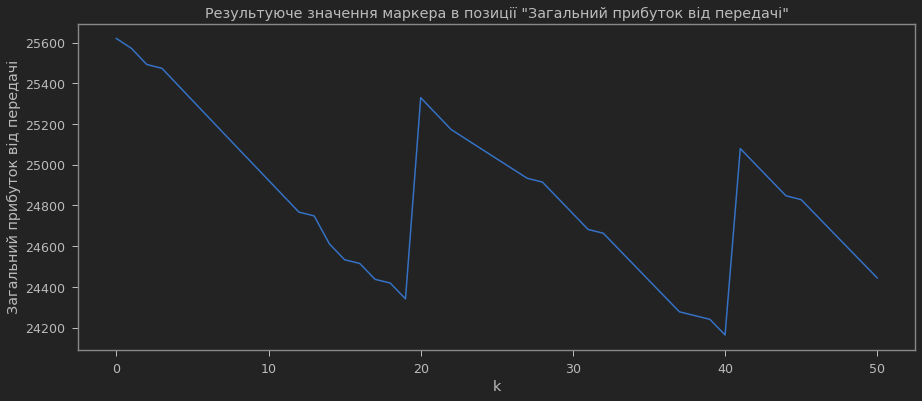

In [66]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.plot(temp_xy[:, 0], temp_xy[:, 1])

ax.set_xlabel(u'k')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Загальний прибуток від передачі')
ax.set_title(u'Результуюче значення маркера в позиції "Загальний прибуток від передачі"');

In [67]:
del temp_xy

In [68]:
df.sort_values('Загальний прибуток від передачі', ascending=False).to_excel('assets/verification_T2_freez.xlsx', index=False)

#### Визначення часу моделюваня

In [69]:
T1 = 20
T1_RANGE = 8

T2_basic = 400
T2 = 400
T2_RANGE = 50

T3 = 5

T4 = 100
T4_RANGE = 25

s1 = 60
s2 = 30
s3 = 0.04

R = 18
R_RANGE = 10

k = np.abs(T2_basic - T2)

N_ROUND = 0 # параметр для round()

modeling_period = 100000.0
queue_time = []
process_time = []

# Positions
net = define_model(modeling_period, should_print_intermediate_results=False,
                   T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                   T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
result1 = net.run(return_avg_markers='Резервний канал вільний')

net = define_model(modeling_period, should_print_intermediate_results=False,
                   T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                   T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
result2 = net.run(return_avg_markers='Резервний канал вільний')
clear_output()

In [70]:
mean_per_iter1 = []
mean_per_iter2 = []
for i in tqdm(range(len(result1))):
    mean_per_iter1.append(sum(result1[:i+1]) / len(result1[:i+1]))
    mean_per_iter2.append(sum(result2[:i+1]) / len(result2[:i+1]))

100%|██████████| 100000/100000 [02:13<00:00, 749.86it/s]


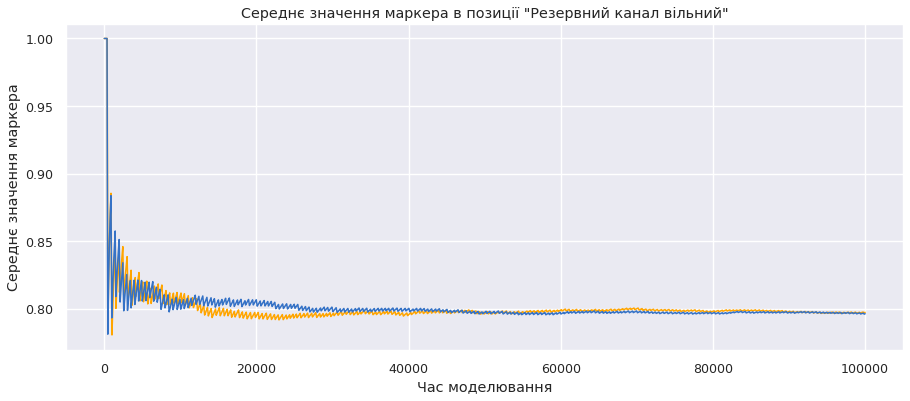

In [100]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.plot(mean_per_iter1, color='orange')
ax.plot(mean_per_iter2)

ax.set_xlabel(u'Час моделювання')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Середнє значення маркера')
ax.set_title(u'Середнє значення маркера в позиції "Резервний канал вільний"');

**Визначений час модеювання: 50000**

#### Визначення кількості прогонів

In [72]:
T1 = 20
T1_RANGE = 8

T2_basic = 400
T2 = 400
T2_RANGE = 50

T3 = 5

T4 = 100
T4_RANGE = 25

s1 = 60
s2 = 30
s3 = 0.04

R = 18
R_RANGE = 10

k = np.abs(T2_basic - T2)

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0

n_exp = 50
y_hat_list = []

for i in tqdm(range(n_exp)):
    net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
    result = net.run(return_target=True)
    y_hat_list.append(result['Загальний прибуток від передачі'])

100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


In [73]:
std_hat = np.std(y_hat_list, ddof=1)
mean_hat = np.mean(y_hat_list)

In [31]:
round(((1.96**2) * (std_hat ** 2) / ((0.01 * mean_hat) ** 2)) + 1)

6.78499112814853

In [32]:
round(((std_hat ** 2) / ((0.01*mean_hat)**2 * (1 - 0.95))) + 1)

30.117613120306775

#### Пошук функції розподілу часу проходження повідомлення в системі

**виконаємо моделювання нашої системи:**

In [55]:
T1 = 20
T1_RANGE = 8

T2_basic = 400
T2 = 400
T2_RANGE = 50

T3 = 5

T4 = 100
T4_RANGE = 25

s1 = 60
s2 = 30
s3 = 0.04

R = 18
R_RANGE = 10

k = np.abs(T2_basic - T2)

N_ROUND = 0 # параметр для round()

modeling_period = 10000000.0
queue_time = []
process_time = []

# Positions
net = define_model(modeling_period, should_print_intermediate_results=False,
                   T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                   T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
result = net.run(return_target=False)

Modeling time spent: 10000000.0


,description,avg_markers,max_markers,min_markers,result_markers
0,Надходження,5.263000e-02,1.0,0,0.0
1,Накопичувач (черга),2.789117e+04,55738.0,0,55738.0
2,Основний канал вільний,2.202900e-01,1.0,0,1.0
3,Резервний канал вільний,7.977400e-01,1.0,0,0.0
4,Буфер,3.899000e-02,1.0,0,0.0
5,Кількість переривань,1.026169e+04,20531.0,0,20531.0
6,Прибуток від передачі основним каналом,1.108250e+07,22163520.0,0,22163520.0
7,Передано основним каналом,1.847083e+05,369392.0,0,369392.0
8,Загальний прибуток від передачі,1.259950e+07,25198980.0,0,25198980.0
9,Загальна кількість переданих повідомлень,2.352752e+05,470574.0,0,470574.0


**визначимо функцію розподілу:**

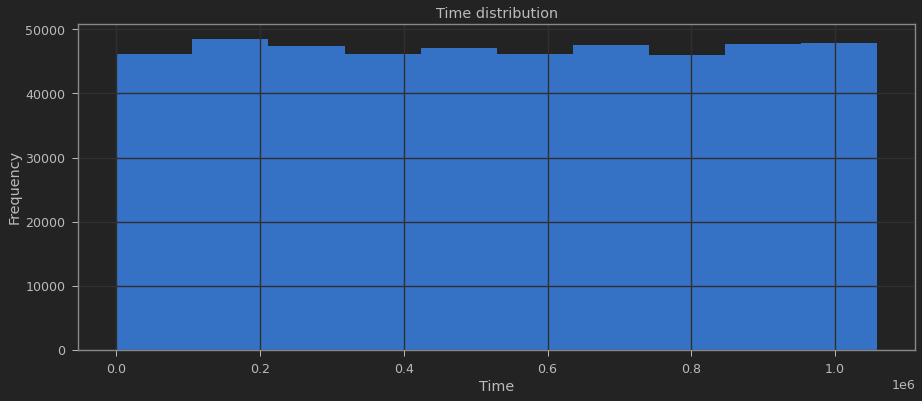

In [71]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.hist(process_time)
ax.grid(True)

ax.set_xlabel(u'Time')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Time distribution');

In [72]:
def create_bins_uniform(x, a, b, n_bins=30, n_min=20):
    start = x.min()
    finish = x.max() + 1e-9
    h = (finish - start) / n_bins
    n = x.size
    
    obs_freq = {}
    exp_freq = {}
    
    current = start

    i = 0
    while current <= finish:
        obs_freq[i] = np.sum((x >= current) & (x < (current+h)))
        p_i = np.abs(st.uniform(a, b).cdf(current) - st.uniform(a, b).cdf(current+h))
        exp_freq[i] = p_i * n
        i += 1
        current += h
    return normilize_bins_uniform(obs_freq, exp_freq, n_min=n_min)

In [73]:
def normilize_bins_uniform(obs_freq, exp_freq, n_min=100):
    assert len(obs_freq) > 2 or len(exp_freq) > 2
        
    for i in sorted(obs_freq.keys(), reverse=True)[:-1]:
        if obs_freq[i] <= n_min or exp_freq[i] <= n_min:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
    
    for i in sorted(obs_freq.keys())[:-1]:
        if obs_freq[i] <= n_min or exp_freq[i] <= n_min:
            j = 1
            while not i+j in obs_freq:
                j += 1
            obs_freq[i+j] += obs_freq[i]
            exp_freq[i+j] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
    
    return obs_freq, exp_freq

$H_0:$ дані мають експоненційний розподіл з заданим параметром $\lambda$

$H_1: H_0$ не виконується

In [74]:
process_time = np.array(process_time)

In [75]:
process_time.max()

1058539.0

In [82]:
x = np.linspace(0,process_time.max(),1000000000)

b = (x.mean() + np.sqrt(3)*x.std(ddof=1))
a = 2*x.mean() - b

observed_freq, expected_freq = create_bins_uniform(process_time, a, b, n_bins=11, n_min=200)

In [83]:
a, b

(-0.793904977850616, 1058539.7939049779)

In [78]:
stat_val, p_value = st.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=2)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [79]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Не можемо прийняти нульову гіпотезу на рівні значемості alpha=0.05.
Значення статистики:
	- stat_val = 96.32051
	- p-value = 0.0


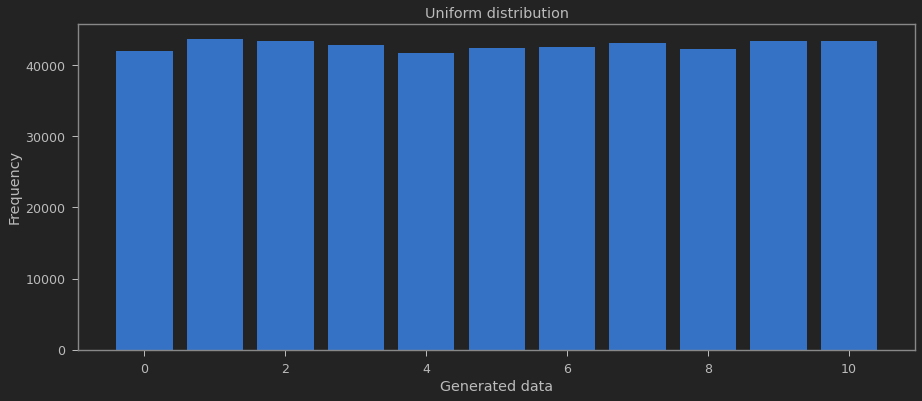

In [80]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.bar(x=list(observed_freq.keys()), height=list(observed_freq.values()))

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');

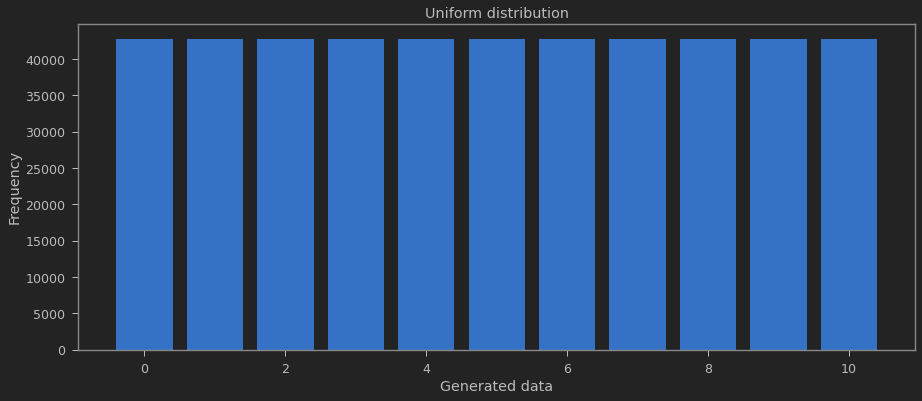

In [81]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.bar(x=list(expected_freq.keys()), height=list(expected_freq.values()))

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');

In [67]:
def get_best_distribution(data):
#     dist_names = ["norm", 'uniform', "exponweib", "pareto", "genextreme", "erlang"]
    dist_names = ['dweibull', 'expon', 'norm', 'uniform']
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("- p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value
    
    print()
    print("Best fitting distribution: " + str(best_dist))
    print("Best p value: " + str(best_p))
    print("Parameters for the best fit: " + str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [68]:
best_dist, p_value, params = get_best_distribution(process_time)

- p value for dweibull = 0.0
- p value for expon = 0.0
- p value for norm = 0.0
- p value for uniform = 1.0055276913977442e-05

Best fitting distribution: uniform
Best p value: 1.0055276913977442e-05
Parameters for the best fit: (35.0, 1058504.0)


In [69]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- p-value = %s' % (round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Найкращий розподіл:', best_dist)
    print('Значення параметрів:')
    print('\t- parameters =', params)
    print('Значення статистики:')
    print('\t- p-value = %s' % (round(p_value, 5)))

Не можемо прийняти нульову гіпотезу на рівні значемості alpha=0.05.
Значення статистики:
	- p-value = 1e-05


#### ANOVA

In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
T1_list = [20]
T1_RANGE_list = [8]

T2_basic = 400
T2_list = list(range(400, 451))
T2_RANGE_list = [50]

T3_list = [5]

T4_list = [100]
T4_RANGE = [25]

s1 = 60
s2 = 30
s3 = 0.04

R_list = [18]
R_RANGE_list = [10]

N_ROUND = 0 # параметр для round()

modeling_period = 10000.0
queue_time = []
process_time = []

df_rows = []
for row in tqdm(product(T1_list, T1_RANGE_list, T2_list, T2_RANGE_list, T3_list, T4_list, T4_RANGE, R_list, R_RANGE_list)):
    T1, T1_RANGE, T2, T2_RANGE, T3, T4, T4_RANGE, R, R_RANGE = row
    k = np.abs(T2_basic - T2)
    
    net = define_model(modeling_period, should_print_intermediate_results=False,
                       T1=T1, T1_RANGE=T1_RANGE, T2=T2, T2_RANGE=T2_RANGE,T2_basic=T2_basic,
                       T3=T3, T4=T4, T4_RANGE=T4_RANGE, R=R, R_RANGE=R_RANGE, s1=s1, s2=s2, s3=s3)
    result = net.run(return_target=True)
    df_rows.append(dict({'T1': T1, 'T1_RANGE': T1_RANGE, 'T2': T2, 'T2_RANGE': T2_RANGE, 'T3': T3,
                    'T4': T4, 'T4_RANGE': T4_RANGE, 'k': k, 's1': s1-k*s3, 's2': s2-k*s3, 's3': s3,
                    'modeling_time': modeling_period}, **result))
    
df = pd.DataFrame(df_rows)
df.head(10)